## Advanced Lane Finding
[![Udacity - Self-Driving Car NanoDegree](https://s3.amazonaws.com/udacity-sdc/github/shield-carnd.svg)](http://www.udacity.com/drive)


In this project, your goal is to write a software pipeline to identify the lane boundaries in a video, but the main output or product we want you to create is a detailed writeup of the project.  Check out the [writeup template](https://github.com/udacity/CarND-Advanced-Lane-Lines/blob/master/writeup_template.md) for this project and use it as a starting point for creating your own writeup.  

Creating a great writeup:
---
A great writeup should include the rubric points as well as your description of how you addressed each point.  You should include a detailed description of the code used in each step (with line-number references and code snippets where necessary), and links to other supporting documents or external references.  You should include images in your writeup to demonstrate how your code works with examples.  

All that said, please be concise!  We're not looking for you to write a book here, just a brief description of how you passed each rubric point, and references to the relevant code :). 

You're not required to use markdown for your writeup.  If you use another method please just submit a pdf of your writeup.

The Project
---

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

The images for camera calibration are stored in the folder called `camera_cal`.  The images in `test_images` are for testing your pipeline on single frames.  If you want to extract more test images from the videos, you can simply use an image writing method like `cv2.imwrite()`, i.e., you can read the video in frame by frame as usual, and for frames you want to save for later you can write to an image file.  

To help the reviewer examine your work, please save examples of the output from each stage of your pipeline in the folder called `output_images`, and include a description in your writeup for the project of what each image shows.    The video called `project_video.mp4` is the video your pipeline should work well on.  

The `challenge_video.mp4` video is an extra (and optional) challenge for you if you want to test your pipeline under somewhat trickier conditions.  The `harder_challenge.mp4` video is another optional challenge and is brutal!

If you're feeling ambitious (again, totally optional though), don't stop there!  We encourage you to go out and take video of your own, calibrate your camera and show us how you would implement this project from scratch!

Rubric: https://review.udacity.com/#!/rubrics/571/view

## How to write a README
A well written README file can enhance your project and portfolio.  Develop your abilities to create professional README files by completing [this free course](https://www.udacity.com/course/writing-readmes--ud777).




### Calibration

#### 1. Compute the camera calibration matrix and distortion coefficients given a set of chessboard images

In [117]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle
%matplotlib inline

In [118]:
def calc_calibration_points(images, n_x, n_y):
    '''
    This function takes a series of chessboard images taken with the camera for which the calibration points are
    to be calculated. The number of chessboard corners in x and y direction must be counted manually and passed
    to the function as well. "Chessboard corners" are only points where two black and two white squares 
    intersect.
    The function returns all recognized chessboard corners in the following way:
    object_points: a list of 3D points corresponding to the location of the corners in real world coordinates
    image_points: a list of 2D points corresponding to the location of the corners in image space
    '''
    # Prepare object points, like (0,0,0), (1,0,0), (2,0,0), ...
    object_points_current = np.zeros((n_x*n_y, 3), np.float32)
    object_points_current[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1, 2)

    # Arrays to store object points and image points from all the images
    object_points = [] # 3d points (enumeration of the corners) in real world space
    image_points = [] # 2d points in image plane

    # Step through the list and search for chessboard corners
    for idx, fname in enumerate(images):
        image = cv2.imread(fname)
        image_grayscale = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(image_grayscale, (n_x,n_y), None)

        # If found, add object points, image points
        if ret == True:
            object_points.append(object_points_current)
            image_points.append(corners)

            # Draw and display the corners
            cv2.drawChessboardCorners(image, (n_x,n_y), corners, ret)
            write_name = 'camera_cal/corners_found' + str(idx) + '.jpg'
            cv2.imwrite(write_name, image)
            cv2.imshow('Image', image)
            cv2.waitKey(500)

    cv2.destroyAllWindows()
    
    return object_points, image_points

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

# Counted chessboard corners
n_x = 9
n_y = 6

# Get object_points and image_points for calibration
object_points, image_points = calc_calibration_points(images, n_x, n_y)

# Read in image used for calibration
image = cv2.imread('camera_cal/calibration3.jpg')
image_size = (image.shape[1], image.shape[0])

# Calibrate camera given object_points and image_points
# Function returns reprojection error, camera matrix, distortion coefficients, rotation and translation 
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(object_points, image_points, image_size, None, None)
    
# Save camera calibration result for later use
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump(dist_pickle, open("camera_cal/dist_pickle.p", "wb"))

Text(0.5,1,'Undistorted Image')

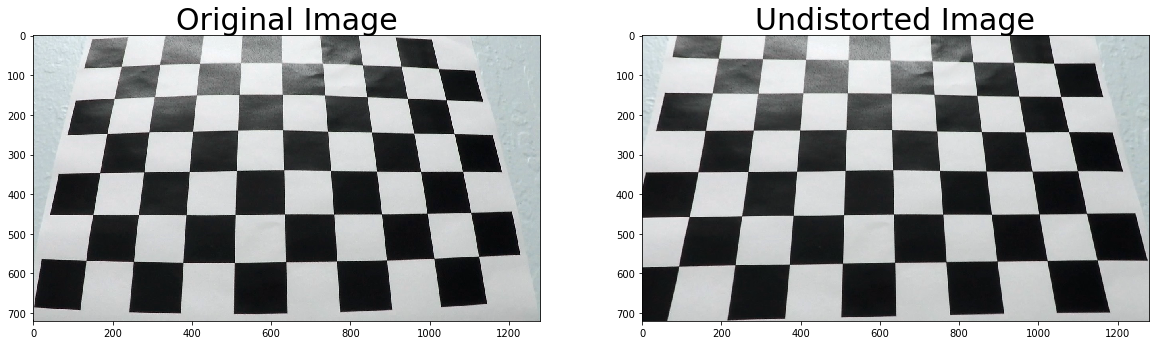

In [119]:
# Undistort image
image_undistorted = cv2.undistort(image, mtx, dist, None, mtx)

# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(image_undistorted)
ax2.set_title('Undistorted Image', fontsize=30)

In [120]:
def calc_transform_matrix_chessboard(image_undistorted, n_x, n_y, mtx, dist, offset):
    '''
    This function takes the undistorted color image of a chessboard for which the perspective transform matrix 
    is to be calculated. The number of chessboard corners in x and y direction must be counted manually and 
    passed to the function alongside the camera's distortion coefficients dist and the target offset of the 
    corners from the image edges in topview image. "Chessboard corners" are only points where two black and two 
    white squares intersect.
    The function returns the perspective transform matrix.
    '''
    # Grayscale image
    image_grayscale = cv2.cvtColor(image_undistorted, cv2.COLOR_BGR2GRAY)

    # Find chessboard corners
    # Function returns non-zero value ret if all corners are found
    ret, corners = cv2.findChessboardCorners(image_grayscale, (n_x, n_y), None)
    cv2.drawChessboardCorners(image_undistorted, (n_x,n_y), corners, ret)

    if ret == True:
        # Define source and destination coordinates
        src = np.float32([corners[0], corners[n_x-1], corners[-1], corners[-n_x]])

        dst = np.float32([[offset, offset], [image_size[0]-offset, offset], [image_size[0]-offset, image_size[1]-offset], [offset, image_size[1]-offset]])

        # Get transform matrix M
        M = cv2.getPerspectiveTransform(src, dst)
        return M
    else:
        print("Not all chessboard corners were found. Try using a different image for obtaining the transform matrix!")

# Offset of corners from image edges in unwarped image
offset = 100

# Calculate transform
M = calc_transform_matrix_chessboard(image_undistorted, n_x, n_y, mtx, dist, offset)
image_topview = cv2.warpPerspective(image_undistorted, M, image_size)

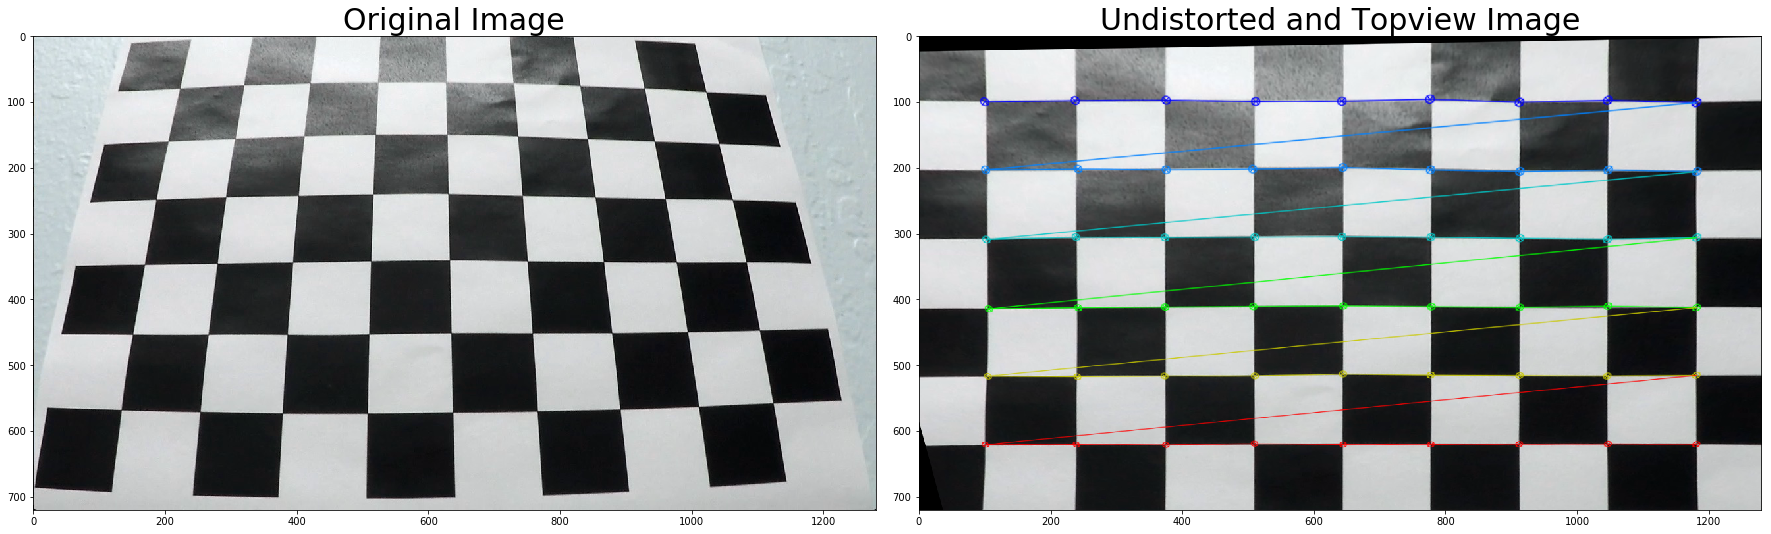

In [121]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(image_topview)
ax2.set_title('Undistorted and Topview Image', fontsize=30)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

### Pipeline (test images)

#### 1. Apply a distortion correction to raw images

Text(0.5,1,'Undistorted Image')

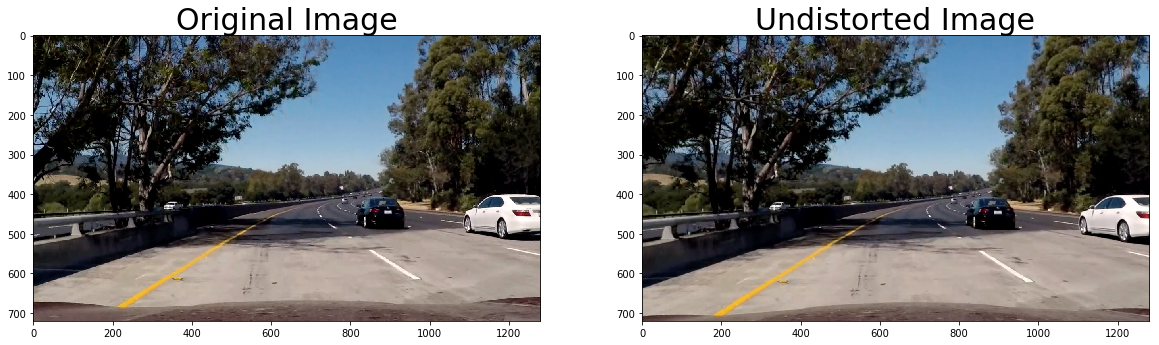

In [122]:
image = mpimg.imread('test_images/test5.jpg')

# Read in the saved camera matrix and distortion coefficients
dist_pickle = pickle.load(open("camera_cal/dist_pickle.p", "rb"))
mtx = dist_pickle["mtx"]
dist = dist_pickle["dist"]
image_undistorted = cv2.undistort(image, mtx, dist, None, mtx)

# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(image_undistorted)
ax2.set_title('Undistorted Image', fontsize=30)

#### 2. Use color transforms, gradients, etc. to create a thresholded binary image

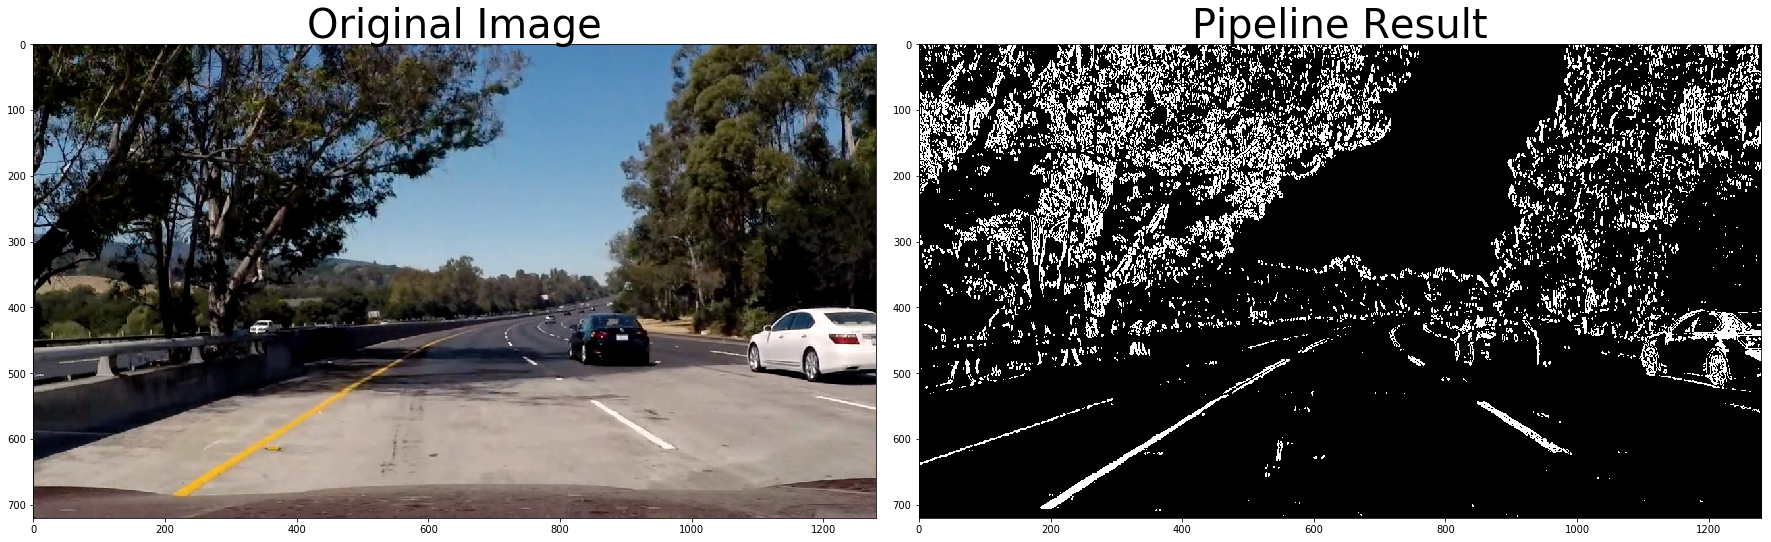

In [123]:
def abs_threshold(image, orient='x', sobel_kernel=3, thresh_min=0, thresh_max=255):
    '''
    This function takes a single channel image (e.g. grayscale), applies the Sobel operator in orient='x' or 
    orient='y' orientation with the the specified kernel, then takes the absolute value, scales the image back to 
    (0,255) and applies the specified threshold.
    '''
    # Convert to grayscale
    sobel = np.copy(image)*0

    # Take the derivative in x or y given orient='x' or 'y'
    if orient == 'x':
        sobel = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    else:
        sobel = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    # Take the absolute value of the derivative or gradient
    abs_sobel = np.absolute(sobel)
    
    # Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255 * abs_sobel / np.max(abs_sobel))

    # Create a binary mask where thresh_min and thresh_max are met
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    
    return binary_output

def mag_threshold(image, sobel_kernel=3, mag_thresh=(0, 255)):
    '''
    This function applies the Sobel operator in x and y orientation separately with the the specified kernel, then 
    calculates the magnitude using np.sqrt(), scales the image back to (0,255) and applies the specified threshold.
    '''
    # Convert to grayscale
    image_grayscale = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    
    # Take the gradient in x and y separately
    sobel_x = cv2.Sobel(image_grayscale, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobel_y = cv2.Sobel(image_grayscale, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    # Calculate the magnitude
    sobel_magnitude = np.sqrt(sobel_x**2 + sobel_y**2)
    
    # Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scale_factor = 255 / np.max(sobel_magnitude)
    
    scaled_sobel_magnitude = np.uint8(sobel_magnitude * scale_factor)

    # Create a binary mask where mag thresholds are met
    binary_output = np.zeros_like(scaled_sobel_magnitude)
    binary_output[(scaled_sobel_magnitude >= mag_thresh[0]) & (scaled_sobel_magnitude <= mag_thresh[1])] = 1
    
    return binary_output

def dir_threshold(image, sobel_kernel=3, thresh=(0, np.pi/2)):
    '''
    This function applies the Sobel operator in x and y orientation separately with the the specified kernel, then 
    calculates the direction of the gradient using np.arctan2() and applies the specified threshold.
    '''
    # Convert to grayscale
    image_grayscale = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    
    # Take the gradient in x and y separately
    sobel_x = cv2.Sobel(image_grayscale, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobel_y = cv2.Sobel(image_grayscale, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    # Take the absolute value of the x and y gradients
    abs_sobel_x = np.absolute(sobel_x)
    abs_sobel_y = np.absolute(sobel_y)
    
    # Calculate the direction of the gradient 
    sobel_direction = np.arctan2(abs_sobel_y, abs_sobel_x)
    
    # Create a binary mask where direction thresholds are met
    binary_output = np.zeros_like(sobel_direction)
    binary_output[(sobel_direction >= thresh[0]) & (sobel_direction <= thresh[1])] = 1
    
    return binary_output

def apply_thresholds(image, S_thresh, L_thresh, sobel_x_L_thresh, sobel_kernel=3):
    '''
    Build pipeline like below ...
    '''
    # Convert to HLS color space
    image_hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    
    # Get single color channels
    image_S = image_hls[:,:,2]
    image_L = image_hls[:,:,1]
    
    sobel_x_L_binary = abs_threshold(image_L, orient='x', sobel_kernel=ksize, thresh_min=sobel_x_L_thresh[0], thresh_max=sobel_x_L_thresh[1])

    # Threshold color channel
    S_binary = np.zeros_like(image_S)
    S_binary[(image_S >= S_thresh[0]) & (image_S <= S_thresh[1])] = 1
    
    # Threshold L channel
    L_binary = np.zeros_like(image_S)
    L_binary[(image_L >= L_thresh[0]) & (image_L <= L_thresh[1])] = 1

    # Add all binary images into a single binary image
    image_binary = np.zeros_like(image_S)
    image_binary[(sobel_x_L_binary == 1) | (S_binary == 1) & (L_binary == 1)] = 1
    
    return image_binary

# Parameters
ksize = 5
S_thresh=(170, 255)
L_thresh=(20, 255)
sobel_x_L_thresh=(20, 100)

image_binary = apply_thresholds(image_undistorted, S_thresh, L_thresh, sobel_x_L_thresh, sobel_kernel=5)

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(image)
ax1.set_title('Original Image', fontsize=40)

ax2.imshow(image_binary, cmap='gray')
ax2.set_title('Pipeline Result', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

#### 3a. Apply a perspective transform to rectify color image ("birds-eye view")

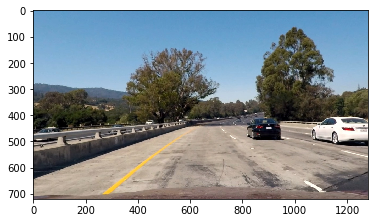

In [124]:
# image = mpimg.imread('test_images/straight_lines1.jpg')
image = mpimg.imread('test_images/test1.jpg')
image_undistorted = cv2.undistort(image, mtx, dist, None, mtx)

image_size = (image_undistorted.shape[1], image_undistorted.shape[0]) # (x_size, y_size)
x_size = image_size[0]
y_size = image_size[1]

plt.imshow(image_undistorted)

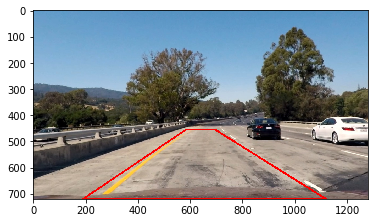

In [125]:
# Corners manually obtained from looking at picture
# bottom_left, bottom_right, top_left, top_right
corners = [(190, y_size), (1120, y_size), (585, 455), (695, 455)]

image_undistorted_lines = np.copy(image_undistorted)

# Draw lines corresponding to source points
cv2.line(image_undistorted_lines, corners[0], corners[1], (255,0,0), 5)
cv2.line(image_undistorted_lines, corners[2], corners[3], (255,0,0), 5)
cv2.line(image_undistorted_lines, corners[0], corners[2], (255,0,0), 5)
cv2.line(image_undistorted_lines, corners[1], corners[3], (255,0,0), 5)

plt.imshow(image_undistorted_lines)

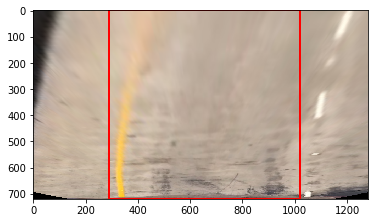

In [126]:
def calc_transform_matrix(image_binary, n_x, n_y, mtx, dist, corners, offset):
    '''
    This function takes the undistorted color image of a chessboard for which the perspective transform matrix 
    is to be calculated. The number of chessboard corners in x and y direction must be counted manually and 
    passed to the function alongside the camera's distortion coefficients dist and the target offset of the 
    corners from the image edges in topview image. "Chessboard corners" are only points where two black and two 
    white squares intersect.
    The function returns the perspective transform matrix.
    '''
    # Find chessboard corners
    # Function returns non-zero value ret if all corners are found
    # ret, corners = cv2.findChessboardCorners(image_grayscale, (n_x, n_y), None)
    # cv2.drawChessboardCorners(image_undistorted, (n_x,n_y), corners, ret)
    
    # Define source and destination coordinates
    src = np.float32([corners[0], corners[1], corners[2], corners[3]])

    # bottom_left, bottom_right, top_left, top_right
    dst = np.float32([(corners[0][0]+offset, corners[0][1]), (corners[1][0]-offset, corners[1][1]), (corners[0][0]+offset, 0), (corners[1][0]-offset, 0)])

    # Get transform matrix M
    M = cv2.getPerspectiveTransform(src, dst)
    return M

offset = 100

# Calculate transform
M = calc_transform_matrix(image_undistorted, n_x, n_y, mtx, dist, corners, offset)

# Warp image
image_topview = cv2.warpPerspective(image_undistorted, M, image_size)

# Draw lines corresponding to destination points
cv2.line(image_topview, (corners[0][0]+offset, corners[0][1]), (corners[1][0]-offset, corners[1][1]), (255,0,0), 5)
cv2.line(image_topview, (corners[0][0]+offset, 0), (corners[1][0]-offset, 0), (255,0,0), 5)
cv2.line(image_topview, (corners[0][0]+offset, corners[0][1]), (corners[0][0]+offset, 0), (255,0,0), 5)
cv2.line(image_topview, (corners[1][0]-offset, corners[1][1]), (corners[1][0]-offset, 0), (255,0,0), 5)

plt.imshow(image_topview)

#### 3b. Apply a perspective transform to rectify binary image

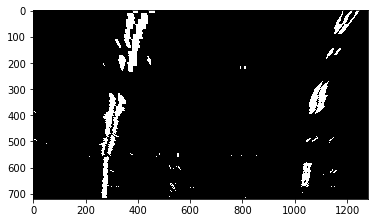

In [127]:
# Warp image
image_binary_topview = cv2.warpPerspective(image_binary, M, image_size)

plt.imshow(image_binary_topview, cmap='gray')

#### 4. Detect lane pixels and fit to find the lane boundary

In [159]:
def calc_histogram(image_binary_topview, plot=0):    
    '''
    TODO: Histogram ... do this only for initialization or after reset!
    '''
    # Grab only the bottom half of the image
    bottom_half = image_binary_topview[image_binary_topview.shape[0]//2:,:]

    # Sum across image pixels vertically
    histogram = np.sum(bottom_half, axis=0)
    
    if plot:
        plt.plot(histogram)
    
    return histogram

In [300]:
def fit_polynomial(image_binary_topview, x_left, y_left, x_right, y_right, draw=0):
    '''
    TODO: This function fits polynomial to pixels ... do this only for initialization or after reset!
    '''
    # Fit a second order polynomial to each line
    # Fit for f(y), rather than f(x), because the lane lines in the warped image are near vertical 
    # and may have the same x value for more than one y value.
    left_fit = np.polyfit(y_left, x_left, 2)
    right_fit = np.polyfit(y_right, x_right, 2)

    # Generate y values for plotting
    y_plot = np.linspace(0, image_binary_topview.shape[0] - 1, image_binary_topview.shape[0])
    
    # Calculate both polynomials using y_plot, left_fit and right_fit
    try:
        x_left_fit = left_fit[0] * y_plot**2 + left_fit[1] * y_plot + left_fit[2]
        x_right_fit = right_fit[0] * y_plot**2 + right_fit[1] * y_plot + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        x_left_fit = 1 * y_plot**2 + 1 * y_plot
        x_right_fit = 1 * y_plot**2 + 1 * y_plot
        
    # Create an output image to draw on and visualize the result
    image_output = np.dstack((image_binary_topview, image_binary_topview, image_binary_topview))
    
    if draw:
        # Visualization
        # Colors in the left and right lane regions
        image_output[y_left, x_left] = [255, 0, 0]
        image_output[y_right, x_right] = [0, 0, 255]

        # Plots the left and right polynomials on the lane lines
        # plt.plot(x_left_fit, y_plot, color='yellow')
        # plt.plot(x_right_fit, y_plot, color='yellow')
        
        # Create an image to draw the lines on
        # warp_zero = np.zeros_like(warped).astype(np.uint8)
        # color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
        
        # Blank image for visualization of lane
        blank_image = np.zeros_like(image_output)
        
        # Recast the x and y points into usable format for cv2.fillPoly()
        points_left = np.array([np.transpose(np.vstack([x_left_fit, y_plot]))])
        points_right = np.array([np.flipud(np.transpose(np.vstack([x_right_fit, y_plot])))])
        points = np.hstack((points_left, points_right))

        # Draw the lane onto the warped blank image
        cv2.fillPoly(blank_image, np.int_([points]), (0,255, 0))

        # Combine the result with the original image
        image_visualization = cv2.addWeighted(image_output, 1, blank_image, 0.3, 0)

    return left_fit, right_fit, image_visualization

In [301]:
def find_lane_pixels(image_binary_topview, draw=0):
    '''
    TODO: This functions finds pixels of lane boundaries based on histogram ... do this only for initialization or after reset!
    '''
    # Take a histogram of the bottom half of the image
    histogram = calc_histogram(image_binary_topview)
    
    # Create an output image to draw on and visualize the result
    image_visualization = np.dstack((image_binary_topview, image_binary_topview, image_binary_topview))
    
    # Find the peak of the left and right halves of the histogram
    # These will be the starting points for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    x_left_base = np.argmax(histogram[:midpoint]) # histogram peak in left half (x coordinate)
    x_right_base = np.argmax(histogram[midpoint:]) + midpoint # histogram peak in right half (x coordinate)

    # Hyperparameters
    # Choose the number of sliding windows
    n_windows = 9
    
    # Set the width of the windows +/- margin
    margin = 100
    
    # Set minimum number of pixels found to recenter window
    min_pixels = 50

    # Set height of windows - image shape divided by number of windows 
    height_window = np.int(image_binary_topview.shape[0]//n_windows)
    
    # Identify x and y positions of all nonzero pixels in the image
    # np.nonzero returns a tuple of arrays containing the indices of the elements that are non-zero
    nonzero = image_binary_topview.nonzero()
    
    # Save array containing indices of non-zero x elements (y elements)
    nonzero_y = np.array(nonzero[0])
    nonzero_x = np.array(nonzero[1])
    
    # Current positions to be updated later for each window in n_windows
    x_left_current = x_left_base
    x_right_current = x_right_base

    # Create empty lists to receive left and right line pixel indices
    indices_left_line = []
    indices_right_line = []

    # Step through the windows one by one
    for window in range(n_windows):
        # Identify window boundaries in x and y (and right and left)
        y_low = image_binary_topview.shape[0] - (window + 1) * height_window # image_binary_topview.shape[0] is y coordinate!
        y_high = image_binary_topview.shape[0] - window * height_window
        
        # Find the four below boundaries of the window
        x_left_low = x_left_current - margin  
        x_left_high = x_left_current + margin
        x_right_low = x_right_current - margin
        x_right_high = x_right_current + margin
        
        if draw:
            # Draw the windows on the visualization image
            cv2.rectangle(image_visualization, (x_left_low,y_low), (x_left_high,y_high), (0,255,0), 2) 
            cv2.rectangle(image_visualization, (x_right_low,y_low), (x_right_high,y_high), (0,255,0), 2) 
        
        # Identify the nonzero pixels in x and y within the window
        indices_window_y = ((nonzero_y >= y_low) & (nonzero_y < y_high))
        indices_window_left_x = ((nonzero_x >= x_left_low) & (nonzero_x < x_left_high))
        indices_window_right_x = ((nonzero_x >= x_right_low) & (nonzero_x < x_right_high))
        
        good_indices_left = (indices_window_y & indices_window_left_x).nonzero()[0]
        good_indices_right = (indices_window_y & indices_window_right_x).nonzero()[0]
        
        # Append these indices to the lists
        indices_left_line.append(good_indices_left)
        indices_right_line.append(good_indices_right)
        
        # If more than min_pixels are found, re-center the next window
        if len(good_indices_left) > min_pixels:
            x_left_current = np.int(np.mean(nonzero_x[good_indices_left]))
        
        if len(good_indices_right) > min_pixels:
            x_right_current = np.int(np.mean(nonzero_x[good_indices_right]))

    # Concatenate the arrays of indices
    try:
        indices_left_line = np.concatenate(indices_left_line)
        indices_right_line = np.concatenate(indices_right_line)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    x_left = nonzero_x[indices_left_line]
    y_left = nonzero_y[indices_left_line] 
    x_right = nonzero_x[indices_right_line]
    y_right = nonzero_y[indices_right_line]
    
    if draw:
        image_visualization[y_left, x_left] = [255, 0, 0]
        image_visualization[y_right, x_right] = [0, 0, 255]

    return x_left, y_left, x_right, y_right, image_visualization

In [302]:
def search_around_polynomial(image_binary_topview, left_fit_previous, right_fit_previous, draw=0):
    # Choose the width of the margin around the previous polynomial to search
    margin = 100

    # Grab activated pixels
    nonzero = image_binary_topview.nonzero()
    nonzero_y = np.array(nonzero[0])
    nonzero_x = np.array(nonzero[1])
    
    # Set the area of search based on activated x-values within the +/- margin of the polynomial function
    # f(y) = x, find area where
    # x > f(y - margin) & x < f(y + margin)
    indices_left_line = ((nonzero_x > (left_fit_previous[0] * (nonzero_y**2) + left_fit_previous[1] * nonzero_y + left_fit_previous[2] - margin)) 
                         & (nonzero_x < (left_fit_previous[0] * (nonzero_y**2) + left_fit_previous[1] * nonzero_y + left_fit_previous[2] + margin)))
    indices_right_line = ((nonzero_x > (right_fit_previous[0] * (nonzero_y**2) + right_fit_previous[1] * nonzero_y + right_fit_previous[2] - margin)) 
                         & (nonzero_x < (right_fit_previous[0] * (nonzero_y**2) + right_fit_previous[1] * nonzero_y + right_fit_previous[2] + margin)))
    
    # Again, extract left and right line pixel positions
    x_left = nonzero_x[indices_left_line]
    y_left = nonzero_y[indices_left_line] 
    x_right = nonzero_x[indices_right_line]
    y_right = nonzero_y[indices_right_line]
    
    # Create an image to draw on and an image to show the selection window
    image_visualization = np.dstack((image_binary_topview, image_binary_topview, image_binary_topview))*255
    
    if draw:
    
        # Create an image to draw on and an image to show the selection window
        image_output = np.copy(image_visualization)
    
        # Generate x and y values for plotting
        y_plot = np.linspace(0, image_binary_topview.shape[0] - 1, image_binary_topview.shape[0])

        # Calculate both polynomials using y_plot, left_fit and right_fit
        try:
            x_left_fit_previous = left_fit_previous[0] * y_plot**2 + left_fit_previous[1] * y_plot + left_fit_previous[2]
            x_right_fit_previous = right_fit_previous[0] * y_plot**2 + right_fit_previous[1] * y_plot + right_fit_previous[2]
        except TypeError:
            # Avoids an error if `left` and `right_fit` are still none or incorrect
            print('The function failed to fit a line!')
            x_left_fit_previous = 1 * y_plot**2 + 1 * y_plot
            x_right_fit_previous = 1 * y_plot**2 + 1 * y_plot

        # Visualization
        blank_image = np.zeros_like(image_output)
        
        # Color in left and right line pixels
        image_output[nonzero_y[indices_left_line], nonzero_x[indices_left_line]] = [255, 0, 0]
        image_output[nonzero_y[indices_right_line], nonzero_x[indices_right_line]] = [0, 0, 255]

        # Generate a polygon to illustrate the search window area
        # And recast the x and y points into usable format for cv2.fillPoly()
        left_line_window_1 = np.array([np.transpose(np.vstack([x_left_fit_previous - margin, y_plot]))])
        left_line_window_2 = np.array([np.flipud(np.transpose(np.vstack([x_left_fit_previous + margin, y_plot])))])
        left_line_pts = np.hstack((left_line_window_1, left_line_window_2))
        right_line_window1 = np.array([np.transpose(np.vstack([x_right_fit_previous - margin, y_plot]))])
        right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([x_right_fit_previous + margin, y_plot])))])
        right_line_pts = np.hstack((right_line_window1, right_line_window2))

        # Draw the lane onto the warped blank image
        cv2.fillPoly(blank_image, np.int_([left_line_pts]), (0,255, 0))
        cv2.fillPoly(blank_image, np.int_([right_line_pts]), (0,255, 0))
        image_visualization = cv2.addWeighted(image_output, 1, blank_image, 0.3, 0)

        # Plot the polynomial lines onto the image
        plt.plot(x_left_fit_previous, y_plot, color='yellow')
        plt.plot(x_right_fit_previous, y_plot, color='yellow')
    
    return x_left, y_left, x_right, y_right, image_visualization

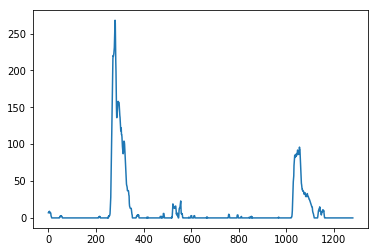

In [303]:
histogram = calc_histogram(image_binary_topview, plot=1)

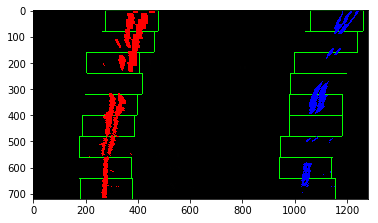

In [304]:
x_left, y_left, x_right, y_right, image_visualization = find_lane_pixels(image_binary_topview, draw=1)

plt.imshow(image_visualization)

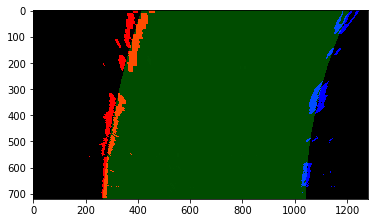

In [305]:
left_fit, right_fit, image_visualization = fit_polynomial(image_binary_topview, x_left, y_left, x_right, y_right, draw=1)

plt.imshow(image_visualization)

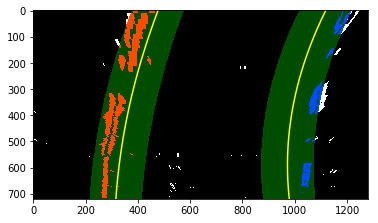

In [299]:
# Polynomial fit values from the previous frame
left_fit_previous = np.array([ 2.13935315e-04, -3.77507980e-01,  4.76902175e+02])
right_fit_previous = np.array([4.17622148e-04, -4.93848953e-01,  1.11806170e+03])

# Run image through the pipeline using the fit from the previous frame
x_left, y_left, x_right, y_right, image_visualization = search_around_polynomial(image_binary_topview, left_fit_previous, right_fit_previous, draw=1)

# View your output
plt.imshow(image_visualization)

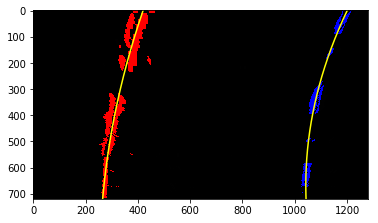

In [256]:
left_fit, right_fit, image_visualization = fit_polynomial(image_binary_topview, x_left, y_left, x_right, y_right, draw=1)

# View your output
plt.imshow(image_visualization)

#### 5. Determine the curvature of the lane and vehicle position with respect to center

#### 6. Warp the detected lane boundaries back onto the original image

In [292]:
'''
# Create an image to draw the lines on
warp_zero = np.zeros_like(warped).astype(np.uint8)
color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

# Recast the x and y points into usable format for cv2.fillPoly()
pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
pts = np.hstack((pts_left, pts_right))

# Draw the lane onto the warped blank image
cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

# Warp the blank back to original image space using inverse perspective matrix (Minv)
newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
# Combine the result with the original image
result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
plt.imshow(result)
'''

'\n# Create an image to draw the lines on\nwarp_zero = np.zeros_like(warped).astype(np.uint8)\ncolor_warp = np.dstack((warp_zero, warp_zero, warp_zero))\n\n# Recast the x and y points into usable format for cv2.fillPoly()\npts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])\npts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])\npts = np.hstack((pts_left, pts_right))\n\n# Draw the lane onto the warped blank image\ncv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))\n\n# Warp the blank back to original image space using inverse perspective matrix (Minv)\nnewwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) \n# Combine the result with the original image\nresult = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)\nplt.imshow(result)\n'

#### 7. Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position

### Pipeline (video)

In [ ]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML
from collections import deque

In [265]:
class Line():
    '''
    TODO: This class ... to receive and save the characteristics of each line detection
    '''
    def __init__(self):
        # Was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        # Average x values of the fitted line over the last n iterations
        self.bestx = None     
        # Polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        # Polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        # Radius of curvature of the line in some units
        self.radius_of_curvature = None 
        # Distance in meters of vehicle center from the line
        self.line_base_pos = None 
        # Difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        # x values for detected line pixels
        self.allx = None  
        # y values for detected line pixels
        self.ally = None

In [306]:
def process_image(image):
    # Parameters
    ksize = 5
    S_thresh=(170, 255)
    L_thresh=(20, 255)
    sobel_x_L_thresh=(20, 100)
    
    # Get camera calibration data
    dist_pickle = pickle.load(open("camera_cal/dist_pickle.p", "rb"))
    mtx = dist_pickle["mtx"]
    dist = dist_pickle["dist"]
    
    image_size = (image.shape[1], image.shape[0]) # (x_size, y_size)
    
    # 1. Apply thresholds
    image_binary = apply_thresholds(image, S_thresh, L_thresh, sobel_x_L_thresh, sobel_kernel=5)
    
    # 2. Undistort using camera calibration parameters mtx and dist
    image_binary_undistorted = cv2.undistort(image_binary, mtx, dist, None, mtx)
    
    # 3. Warp image using transform matrix M
    image_binary_topview = cv2.warpPerspective(image_binary_undistorted, M, image_size)
    
    # 4. Detect lane pixels and fit to find lane boundary
    if lines_history:
        # There are some good lines in the history
        
        # Get fit data from previous frame (= the one that was added last)
        # d[-1]
        line_left_previous = lines_history[-1][0]
        line_right_previous = lines_history[-1][1]
        
        # 4.1. Run image through pipeline using fit from previous frame
        x_left, y_left, x_right, y_right, image_visualization = search_around_polynomial(image_binary_topview, left_fit_previous, right_fit_previous, draw=0)
    else:
        # There are no good lines in the history
        
        # Calculate fit data from scratch
        x_left, y_left, x_right, y_right, image_visualization = find_lane_pixels(image_binary_topview, draw=0)
    
    left_fit, right_fit, image_visualization = fit_polynomial(image_binary_topview, x_left, y_left, x_right, y_right, draw=1)
        
    # Calculate Line parameters for current lines, smooth x and polynomials
    line_left = Line()
    line_right = Line()
    
    # Do some sanity checks
    if True:
        # Current frame is good, add lines to history
        lines_history.append([line_left, line_right])
    
    else:
        # Current frame is bad, use parameters of last frame instead and pop the oldest element from the deque
        pass
    
    return image_visualization
    # return image_topview

In [307]:
# Parameters
max_history = 5 # the last max_history frames are used for averaging

lines_history = deque(maxlen=max_history)

In [308]:
white_output = 'output_videos/project_video.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
clip1 = VideoFileClip("project_video.mp4").subclip(0,5)
# clip1 = VideoFileClip("project_video.mp4")

white_clip = clip1.fl_image(process_image) # NOTE: this function expects color images!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video output_videos/project_video.mp4
[MoviePy] Writing video output_videos/project_video.mp4


 99%|█████████▉| 125/126 [00:12<00:00,  9.83it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_videos/project_video.mp4 

CPU times: user 23.4 s, sys: 2.16 s, total: 25.5 s
Wall time: 12.8 s


In [309]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

Offset
You can assume the camera is mounted at the center of the car, such that the lane center is the midpoint at the bottom of the image between the two lines you've detected. The offset of the lane center from the center of the image (converted from pixels to meters) is your distance from the center of the lane.

Tracking
After you've tuned your pipeline on test images, you'll run on a video stream, just like in the first project. In this case, however, you're going to keep track of things like where your last several detections of the lane lines were and what the curvature was, so you can properly treat new detections. To do this, it's useful to define a Line() class to keep track of all the interesting parameters you measure from frame to frame. Here's an example:

# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None  
You can create an instance of the Line() class for the left and right lane lines to keep track of recent detections and to perform sanity checks.

Sanity Check
Ok, so your algorithm found some lines. Before moving on, you should check that the detection makes sense. To confirm that your detected lane lines are real, you might consider:

Checking that they have similar curvature
Checking that they are separated by approximately the right distance horizontally
Checking that they are roughly parallel
Look-Ahead Filter
Once you've found the lane lines in one frame of video, and you are reasonably confident they are actually the lines you are looking for, you don't need to search blindly in the next frame. You can simply search within a window around the previous detection.

For example, if you fit a polynomial, then for each y position, you have an x position that represents the lane center from the last frame. Search for the new line within +/- some margin around the old line center.

If you need a reminder on how this works, make sure to go back and check the Finding the Lines: Search from Prior quiz from last lesson!

Then check that your new line detections makes sense (i.e. expected curvature, separation, and slope).

Reset
If your sanity checks reveal that the lane lines you've detected are problematic for some reason, you can simply assume it was a bad or difficult frame of video, retain the previous positions from the frame prior and step to the next frame to search again. If you lose the lines for several frames in a row, you should probably start searching from scratch using a histogram and sliding window, or another method, to re-establish your measurement.

Smoothing
Even when everything is working, your line detections will jump around from frame to frame a bit and it can be preferable to smooth over the last n frames of video to obtain a cleaner result. Each time you get a new high-confidence measurement, you can append it to the list of recent measurements and then take an average over n past measurements to obtain the lane position you want to draw onto the image.

Drawing
Once you have a good measurement of the line positions in warped space, it's time to project your measurement back down onto the road! Let's suppose, as in the previous example, you have a warped binary image called warped, and you have fit the lines with a polynomial and have arrays called ploty, left_fitx and right_fitx, which represent the x and y pixel values of the lines. You can then project those lines onto the original image as follows:

# Create an image to draw the lines on
warp_zero = np.zeros_like(warped).astype(np.uint8)
color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

# Recast the x and y points into usable format for cv2.fillPoly()
pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
pts = np.hstack((pts_left, pts_right))

# Draw the lane onto the warped blank image
cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

# Warp the blank back to original image space using inverse perspective matrix (Minv)
newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
# Combine the result with the original image
result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
plt.imshow(result)